Saving Content.zip to Content (1).zip
Checking training directory:
Directory: /content/Content/datasets/train
Contains 1 files
Directory: /content/Content/datasets/train/TB
Contains 362 files
Directory: /content/Content/datasets/train/CPA
Contains 362 files

Checking validation directory:
Directory: /content/Content/datasets/val
Contains 1 files
Directory: /content/Content/datasets/val/TB
Contains 123 files
Directory: /content/Content/datasets/val/CPA
Contains 123 files

Checking test directory:
Directory: /content/Content/datasets/test
Contains 1 files
Directory: /content/Content/datasets/test/TB
Contains 123 files
Directory: /content/Content/datasets/test/CPA
Contains 124 files
Found 723 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
Found 247 images belonging to 2 classes.
Number of training samples: 723
Number of validation samples: 246
Number of test samples: 247
Epoch 1/50
22/22 [==============================] - 9s 277ms/step - loss: 0.6953 - accuracy: 0

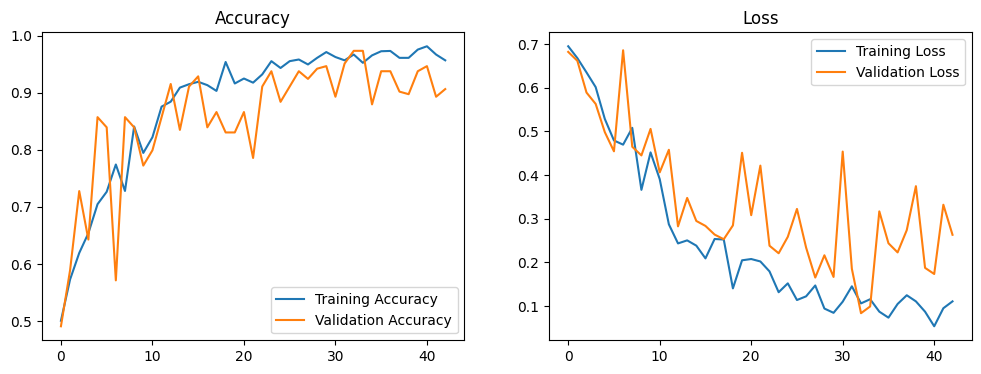

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files
import zipfile

# Upload files directly
uploaded = files.upload()

# Extract the uploaded zip files
for filename in uploaded.keys():
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall('/content')
    zip_ref.close()

# Define paths for the dataset
train_dir = '/content/Content/datasets/train'
val_dir = '/content/Content/datasets/val'
test_dir = '/content/Content/datasets/test'

# Function to list directories and count images
def list_directories_and_count_images(path):
    for root, dirs, files in os.walk(path):
        print(f'Directory: {root}')
        if len(files) > 0:
            print(f'Contains {len(files)} files')

# Check the contents of each directory
print("Checking training directory:")
list_directories_and_count_images(train_dir)
print("\nChecking validation directory:")
list_directories_and_count_images(val_dir)
print("\nChecking test directory:")
list_directories_and_count_images(test_dir)

# Define ImageDataGenerators for loading and augmenting images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,  # Increased batch size
                                                    class_mode='binary',
                                                    color_mode='grayscale')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(150, 150),
                                                batch_size=32,
                                                class_mode='binary',
                                                color_mode='grayscale')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=32,
                                                  class_mode='binary',
                                                  color_mode='grayscale')

# Print the number of samples in each generator
print(f'Number of training samples: {train_generator.samples}')
print(f'Number of validation samples: {val_generator.samples}')
print(f'Number of test samples: {test_generator.samples}')

# Ensure that we have sufficient images to proceed with training
if train_generator.samples > 0 and val_generator.samples > 0 and test_generator.samples > 0:
    # Define the CNN model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

    # Train the model
    history = model.fit(train_generator,
                        steps_per_epoch=max(1, train_generator.samples // train_generator.batch_size),
                        epochs=50,
                        validation_data=val_generator,
                        validation_steps=max(1, val_generator.samples // val_generator.batch_size),
                        callbacks=[early_stopping, model_checkpoint])

    # Load the best model
    model.load_weights('best_model.h5')

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_generator, steps=max(1, test_generator.samples // test_generator.batch_size))
    print(f'Test accuracy: {test_acc:.2f}')

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()
    model_path = '/content/drive/MyDrive/first_draft_classifier.h5'  # Replace with your desired path
    model.save(model_path)

else:
    print("Please ensure that your dataset directories contain images and try again.")




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from google.colab import files

# Function to preprocess the uploaded image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(150, 150), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Load the trained model
model = load_model('best_model.h5')

# Function to predict the class of the uploaded image with rejection option
def predict_image_class(image_path, threshold=0.5):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)[0][0]  # Get the prediction probability
    if prediction < threshold - 0.2:  # Adjust this margin based on experimentation
        return "TB"
    elif prediction > threshold + 0.2:  # Adjust this margin based on experimentation
        return "CPA"
    else:
        return "Uncertain - Image may not belong to TB or CPA"

# Upload the image file
uploaded = files.upload()

# Process and predict the class for each uploaded image
for filename in uploaded.keys():
    uploaded_image_path = filename
    predicted_class = predict_image_class(uploaded_image_path)
    print(f"Uploaded Image: {filename}, Predicted Class: {predicted_class}")


Saving Tuberculosis-700.png to Tuberculosis-700.png
1/1 [==============================] - 0s 79ms/step
Uploaded Image: Tuberculosis-700.png, Predicted Class: TB
